In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

# Lecture 1: Recurrent Neural Networks
---



In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Take every 5th entry as the testing set

test_batches = tf.data.experimental.cardinality(test_dataset)
test_dataset = test_dataset.take(test_batches // 5)
validation_dataset = test_dataset.skip(test_batches // 5)

In [ ]:
BUFFER_SIZE = 10000
# Buffering: determines how much you can load in pieces
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000 # All vectors should be less than 1000 words (based on IMDB data)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text)) # Train on the training set

In [ ]:
### New Code Here! ###
# mask_zero: if there isn't 1000 words, cover up the places that had no words

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    # the 64 can be anything you want
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)), # outut_dim and SimpleRNN dimension must match b/c they connect
    tf.keras.layers.Dense(64, activation='relu'), # This 64 does not have to match but this just apparently just for convenience
    tf.keras.layers.Dense(1)
])

### End New Code ###

base_learning_rate = 0.001

model_optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model_loss=tf.keras.losses.BinaryCrossentropy()
model_accuracy_metric=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')

model.compile(optimizer=model_optimizer, loss=model_loss,
              metrics=[model_accuracy_metric])

model_epochs = 10

model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                       restore_best_weights=True,
                                                       monitor='val_loss')

model_history = model.fit(train_dataset, epochs=model_epochs,
                        #  validation_data=validation_dataset,
                         callbacks=[model_early_stopping])

model_accuracy = model_history.history['binary_accuracy']
model_val_accuracy = model_history.history['val_binary_accuracy']

model_loss = model_history.history['loss']
model_val_loss = model_history.history['val_loss']

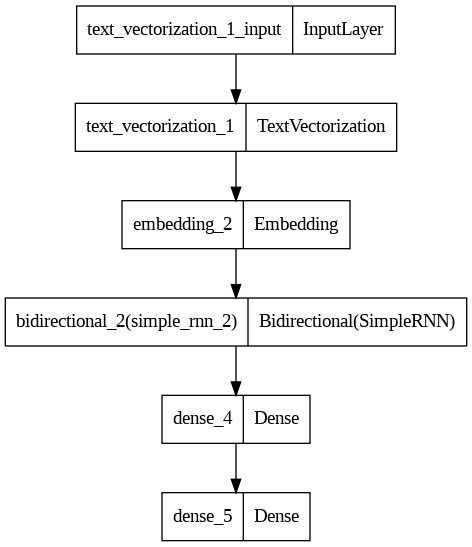

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               16512     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 88833 (347.00 KB)
Trainable params: 8883

# Lecture 2: Reading in Time Series Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Repo/tabular_data/D202.csv')

In [ ]:
print(data)

                 TYPE        DATE START TIME END TIME  USAGE UNITS    COST  \
0      Electric usage  10/22/2016       0:00     0:14   0.01   kWh  $0.00    
1      Electric usage  10/22/2016       0:15     0:29   0.01   kWh  $0.00    
2      Electric usage  10/22/2016       0:30     0:44   0.01   kWh  $0.00    
3      Electric usage  10/22/2016       0:45     0:59   0.01   kWh  $0.00    
4      Electric usage  10/22/2016       1:00     1:14   0.01   kWh  $0.00    
...               ...         ...        ...      ...    ...   ...     ...   
70363  Electric usage  10/24/2018      22:45    22:59   0.02   kWh  $0.00    
70364  Electric usage  10/24/2018      23:00    23:14   0.03   kWh  $0.01    
70365  Electric usage  10/24/2018      23:15    23:29   0.03   kWh  $0.01    
70366  Electric usage  10/24/2018      23:30    23:44   0.03   kWh  $0.01    
70367  Electric usage  10/24/2018      23:45    23:59   0.03   kWh  $0.01    

       NOTES  
0        NaN  
1        NaN  
2        NaN  
3  

In [ ]:
data = data.drop(columns=['TYPE', 'NOTES'])

In [ ]:
print(data['UNITS'].unique())

['kWh']


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        70368 non-null  object 
 1   START TIME  70368 non-null  object 
 2   END TIME    70368 non-null  object 
 3   USAGE       70368 non-null  float64
 4   UNITS       70368 non-null  object 
 5   COST        70368 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.2+ MB


In [ ]:
window_size = 20 # This means 20 of the 15-second intervals
input_cols=['USAGE', 'COST']
num_input_cols = len(input_cols)

# Build container to hold our windows
# the number of windows = total amount of data - size of window (b/c we have to miss the last 20 datapoints cause we can't shift the window anymore)
windows_container = np.zeros(((len(data)-window_size), window_size, num_input_cols)) # Everything in pink is a tuple

In [ ]:
data['COST'] = data['COST'].str.replace('$', '')
data['COST'] = pd.to_numeric(data['COST'])

In [ ]:
for i in range(len(data) - window_size):
  windows_container[i,:,:] = data[input_cols].iloc[i:i+window_size]

In [ ]:
print(windows_container[100])

[[0.03 0.01]
 [0.03 0.01]
 [0.03 0.01]
 [0.03 0.01]
 [0.02 0.  ]
 [0.02 0.  ]
 [0.02 0.  ]
 [0.02 0.  ]
 [0.03 0.01]
 [0.03 0.01]
 [0.03 0.01]
 [0.03 0.01]
 [0.81 0.15]
 [0.81 0.15]
 [0.81 0.15]
 [0.81 0.15]
 [0.73 0.13]
 [0.73 0.13]
 [0.73 0.13]
 [0.73 0.13]]
